In [314]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
from pandas.plotting import table
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
import seaborn as sns
sns.set()
from tqdm.notebook import tqdm

# EDA

In [701]:
df = pd.read_csv('HW1_var_12.csv', sep=';')

In [556]:
df.drop('Номер варианта', axis=1, inplace=True)

In [8]:
missing_df = pd.DataFrame(index=df.columns, columns=['Unique', 'NaNCount','NaNPercent', 'ZeroCount', 'ZeroPercent'])

In [40]:
for var in missing_df.index:
    missing_df['Unique'][var] = len(df[var].unique())
    missing_df['NaNCount'][var] = df[var].isna().sum()
    missing_df['NaNPercent'][var]= np.round(df[var].isna().sum()/len(df)*100, 2)
    missing_df['ZeroCount'][var] = (df[var] == 0).sum()
    missing_df['ZeroPercent'][var] = np.round((df[var] == 0).sum()/len(df)*100, 2)

In [90]:
bad = [ ]
for i in range(len(missing_df)):
    if missing_df.iloc[i]['NaNPercent'] > 50:
        bad.append(i)

In [100]:
colors = []
for i in range(43):
    current = []
    for j in range(5):
        if i in bad and j == 2:
            current.append('yellow')
        else:
            current.append('white')
    colors.append(current)

In [196]:
colors_row = []
for i in range(43):
    if i in bad:
        colors_row.append('yellow')
    else:
        colors_row.append('white')

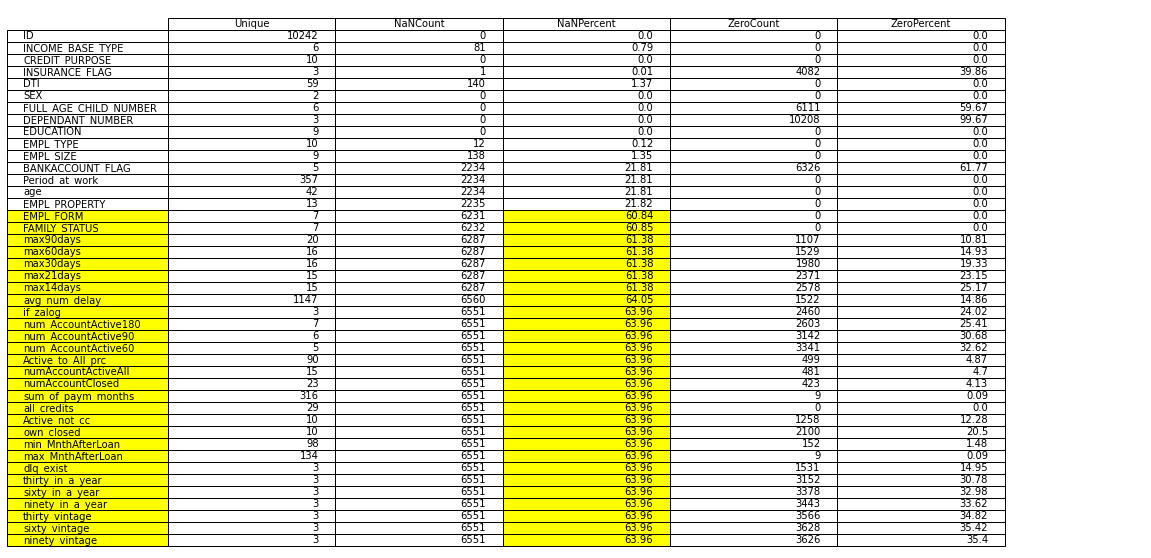

In [197]:
plt.figure(figsize=(20, 10))
ax = plt.subplot(111, frame_on=False)
ax.xaxis.set_visible(False) 
ax.yaxis.set_visible(False)  

table(ax, missing_df,  loc=8, fontsize=50, colWidths=np.full(43, 0.15), 
      cellColours=colors, rowColours=colors_row)
plt.savefig('missing_table')
plt.show()

In [272]:
df.drop('ID', axis=1, inplace=True)

In [273]:
numeric = ['DTI', 'FULL_AGE_CHILD_NUMBER', 'DEPENDANT_NUMBER', 'Period_at_work', 'age', 'max90days',
          'max60days', 'max30days', 'max21days', 'max14days', 'avg_num_delay', 'num_AccountActive180',
          'num_AccountActive90', 'num_AccountActive60', 'Active_to_All_prc', 'numAccountActiveAll', 
          'numAccountClosed', 'sum_of_paym_months', 'all_credits', 'Active_not_cc', 'own_closed', 
          'min_MnthAfterLoan', 'max_MnthAfterLoan', ]

In [275]:
means_df = pd.DataFrame(index=df.columns, columns=['Mean', 'Median', 'SD', 'Max', 'Min', 'Type'])

In [276]:
char = []
cat = []
for var in means_df.index:
    if var not in numeric:
        means_df['Mean'][var] = '-'
        means_df['Median'][var] = '-'
        means_df['SD'][var]= '-'
        means_df['Max'][var] = '-'
        means_df['Min'][var] = '-'
        means_df['Type'][var] = 'cat'
        cat.append(var)
    else:
        means_df['Mean'][var] = round(df[var].mean(), 2)
        means_df['Median'][var] = round(df[var].median(), 2)
        means_df['SD'][var]= round(np.sqrt(df[var].var()), 2)
        means_df['Max'][var] = round(df[var].max(), 2)
        means_df['Min'][var] = round(df[var].min(), 2)
        means_df['Type'][var] = 'numeric'

In [277]:
colors_row = []
for i in range(42):
    if means_df.sort_values(by='Type', ascending=False).index[i] in char:
        colors_row.append('yellow')
    elif means_df.sort_values(by='Type', ascending=False).index[i] in cat:
        colors_row.append('green')
    else:
        colors_row.append('white')

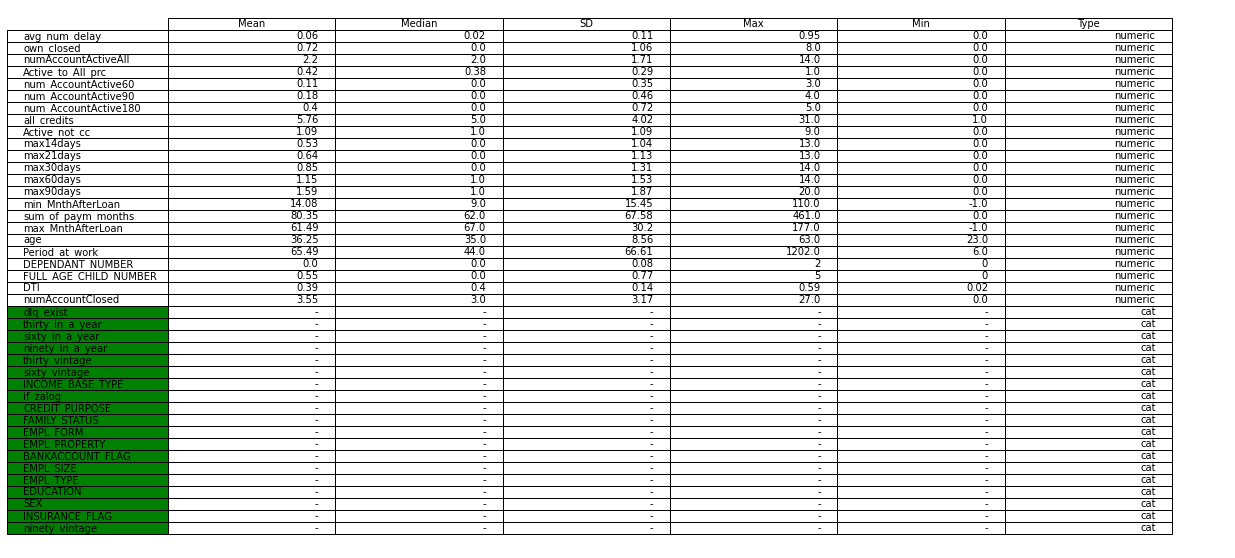

In [278]:
plt.figure(figsize=(20, 10))
ax = plt.subplot(111, frame_on=False)
ax.xaxis.set_visible(False) 
ax.yaxis.set_visible(False)  

table(ax, means_df.sort_values(by='Type', ascending=False),  loc=8, fontsize=50, colWidths=np.full(42, 0.15), 
       rowColours=colors_row)
plt.savefig('means_table')
plt.show()

In [729]:
df = df.dropna(thresh=16)

In [731]:
for var in missing_df[missing_df['NaNPercent'] < 20].drop('ID', axis=0).index:
    df[var].fillna(df[var].value_counts().index[0], inplace=True)

In [732]:
df['EDUCATION'].replace('*n.a.*', df['EDUCATION'].value_counts().index[0], inplace=True)

In [733]:
df['EMPL_SIZE'].replace('*n.a.*', df['EMPL_SIZE'].value_counts().index[0], inplace=True)

In [734]:
df[list(df.drop(numeric, axis=1).drop('ID', axis=1).columns)] = df[list(df.drop(numeric, axis=1).drop('ID', axis=1).columns)].fillna('Unknown')

In [737]:
ints = ['max90days', 'max60days', 'max30days', 'max21days', 'max14days', 'num_AccountActive180',
       'num_AccountActive90', 'num_AccountActive60', 'numAccountActiveAll', 'numAccountClosed', 'Active_not_cc',
       'own_closed', 'min_MnthAfterLoan', 'max_MnthAfterLoan']

In [738]:
df[ints] = df[ints].fillna(-200)

In [741]:
numeric_nans = df[numeric].isna().sum()[df[numeric].isna().sum() != 0].index

In [744]:
df_dummy = pd.get_dummies(df, columns=df.drop(numeric, axis=1).drop('ID', axis=1).columns)

In [791]:
df_dummy_no_miss = df_dummy.drop(numeric_nans[1:], axis=1).drop(ints, axis=1).dropna()
lr = RandomForestRegressor(n_estimators=200)
lr.fit(df_dummy_no_miss.drop(['ID', numeric_nans[0]], axis=1), df_dummy_no_miss[numeric_nans[0]])
df_to_predict = df_dummy[df_dummy[numeric_nans[0]].isna()].drop(numeric_nans[1:], axis=1).drop(ints, axis=1)
df_to_predict[numeric_nans[0]] = lr.predict(df_to_predict.drop(['ID', numeric_nans[0]], axis=1))
df = df.join(df_to_predict.append(df_dummy_no_miss).set_index('ID')[numeric_nans[0]], on='ID', rsuffix='_filled')

In [792]:
df_dummy_no_miss = df_dummy.drop(numeric_nans[0], axis=1).drop(numeric_nans[2:], axis=1).drop(ints, axis=1).dropna()
lr = RandomForestRegressor(n_estimators=200)
lr.fit(df_dummy_no_miss.drop(['ID', numeric_nans[1]], axis=1), df_dummy_no_miss[numeric_nans[1]])
df_to_predict = df_dummy[df_dummy[numeric_nans[1]].isna()].drop(numeric_nans[0], axis=1).drop(numeric_nans[2:], axis=1).drop(ints, axis=1)
df_to_predict[numeric_nans[1]] = lr.predict(df_to_predict.drop(['ID', numeric_nans[1]], axis=1))
df = df.join(df_to_predict.append(df_dummy_no_miss).set_index('ID')[numeric_nans[1]], on='ID', rsuffix='_filled')

In [794]:
df_dummy_no_miss = df_dummy.drop(numeric_nans[0:2], axis=1).drop(numeric_nans[3:], axis=1).drop(ints, axis=1).dropna()
lr = RandomForestRegressor(n_estimators=200)
lr.fit(df_dummy_no_miss.drop(['ID', numeric_nans[2]], axis=1), df_dummy_no_miss[numeric_nans[2]])
df_to_predict = df_dummy[df_dummy[numeric_nans[2]].isna()].drop(numeric_nans[0:2], axis=1).drop(numeric_nans[3:], axis=1).drop(ints, axis=1)
df_to_predict[numeric_nans[2]] = np.round(lr.predict(df_to_predict.drop(['ID', numeric_nans[2]], axis=1)))
df = df.join(df_to_predict.append(df_dummy_no_miss).set_index('ID')[numeric_nans[2]], on='ID', rsuffix='_filled')

In [795]:
df_dummy_no_miss = df_dummy.drop(numeric_nans[0:3], axis=1).drop(numeric_nans[4:], axis=1).drop(ints, axis=1).dropna()
lr = RandomForestRegressor(n_estimators=200)
lr.fit(df_dummy_no_miss.drop(['ID', numeric_nans[3]], axis=1), df_dummy_no_miss[numeric_nans[3]])
df_to_predict = df_dummy[df_dummy[numeric_nans[3]].isna()].drop(numeric_nans[0:3], axis=1).drop(numeric_nans[4:], axis=1).drop(ints, axis=1)
df_to_predict[numeric_nans[3]] = np.round(lr.predict(df_to_predict.drop(['ID', numeric_nans[3]], axis=1)))
df = df.join(df_to_predict.append(df_dummy_no_miss).set_index('ID')[numeric_nans[3]], on='ID', rsuffix='_filled')

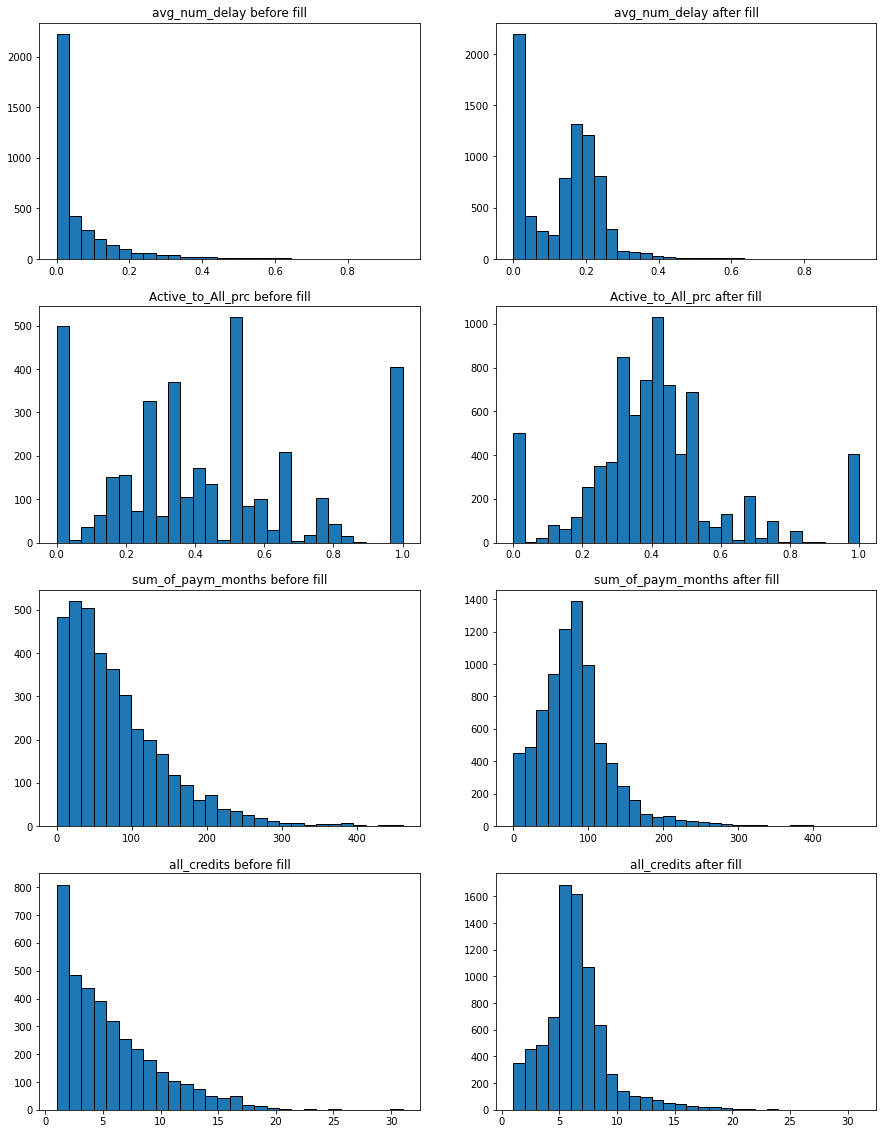

In [798]:
fig, ax = plt.subplots(4, 2, figsize=(15, 20))
for i in range(4):
    for j in range(2):
        if j == 0:
            data = df[numeric_nans[i]][df[numeric_nans[i]].notna()]
            num_bins = 1 + 3.322 * np.log(len(data))
            ax[i][j].hist(data, ec='black', bins=int(num_bins))
            ax[i][j].set_title(f'{numeric_nans[i]} before fill')
        if j == 1:
            data = df[f'{numeric_nans[i]}_filled']
            num_bins = 1 + 3.322 * np.log(len(data))
            ax[i][j].hist(data, ec='black', bins=int(num_bins))
            ax[i][j].set_title(f'{numeric_nans[i]} after fill')
plt.show()

In [1036]:
new_numeric = ['DTI', 'FULL_AGE_CHILD_NUMBER', 'DEPENDANT_NUMBER', 'Period_at_work', 'age', 'max90days',
          'max60days', 'max30days', 'max21days', 'max14days', 'avg_num_delay', 'num_AccountActive180',
          'num_AccountActive90', 'num_AccountActive60', 'Active_to_All_prc', 'numAccountActiveAll', 
          'numAccountClosed', 'sum_of_paym_months', 'all_credits', 'Active_not_cc', 'own_closed', 
          'min_MnthAfterLoan', 'max_MnthAfterLoan', 'all_credits_filled', 'sum_of_paym_months_filled',
               'Active_to_All_prc_filled', 'avg_num_delay_filled']

In [1037]:
df_for_cluster = pd.get_dummies(df, 
                                columns=df.drop(new_numeric, axis=1).drop(['ID', 'Номер варианта'],axis=1).columns).\
drop(['ID', 'Номер варианта', 'all_credits', 'sum_of_paym_months',
               'Active_to_All_prc', 'avg_num_delay'], axis=1)

In [1038]:
df_for_cluster.replace(-200, np.nan, inplace=True)

for column in df_for_cluster.columns:
    df_for_cluster[column].fillna(-1, inplace=True)

# Clusterisation

In [1039]:
scaler = StandardScaler()

In [1040]:
df_for_cluster_scaled = scaler.fit_transform(df_for_cluster)

In [1041]:
pca = PCA(2, random_state=6)
trans = pca.fit_transform(df_for_cluster_scaled)

In [1574]:
pca.explained_variance_ratio_

array([0.23989911, 0.03722206])

In [1042]:
kmeans=KMeans(4)
kmeans.fit(trans)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

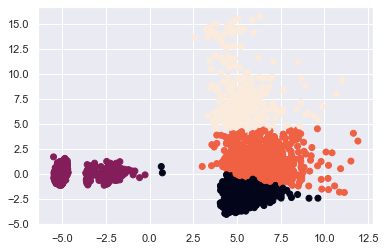

In [1043]:
plt.scatter(trans[:, 0], trans[:, 1], c=kmeans.labels_)
#plt.scatter(db.components_[:,0], db.components_[:,1])
plt.show()

In [ ]:
inertias = []
sils = []
dav = []
for n_clusters in tqdm(np.arange(2, 12)):
    kmeans = KMeans(n_clusters=n_clusters, random_state=6)
    kmeans.fit(df_for_cluster_scaled)
    preds = kmeans.predict(df_for_cluster_scaled)
    sils.append(silhouette_score(df_for_cluster_scaled, preds))
    dav.append(davies_bouldin_score(df_for_cluster_scaled, preds))
    inertias.append(kmeans.inertia_)

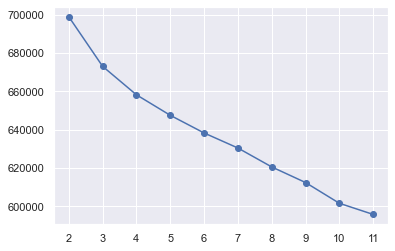

In [1051]:
plt.plot(np.arange(2, 12), inertias, marker='o')
plt.xticks(np.arange(2, 12), np.arange(2, 12))
plt.show()

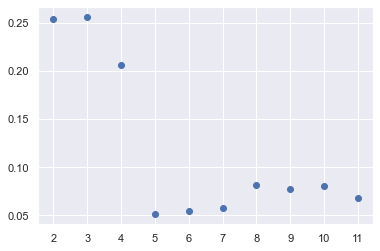

In [1052]:
plt.scatter(np.arange(2, 12), sils)
plt.xticks(np.arange(2, 12), np.arange(2, 12))
plt.show()

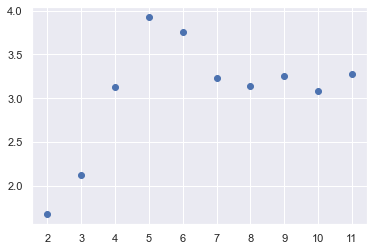

In [1053]:
plt.scatter(np.arange(2, 12), dav)
plt.xticks(np.arange(2, 12), np.arange(2, 12))
plt.show()

In [1078]:
kmeans = KMeans(3, random_state=6)
kmeans.fit(df_for_cluster)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=6, tol=0.0001, verbose=0)

In [1094]:
df['cluster'] = kmeans.predict(df_for_cluster)

In [1134]:
cols = df.drop(new_numeric, axis=1).drop(['ID', 'Номер варианта', 'cluster'], axis=1).columns

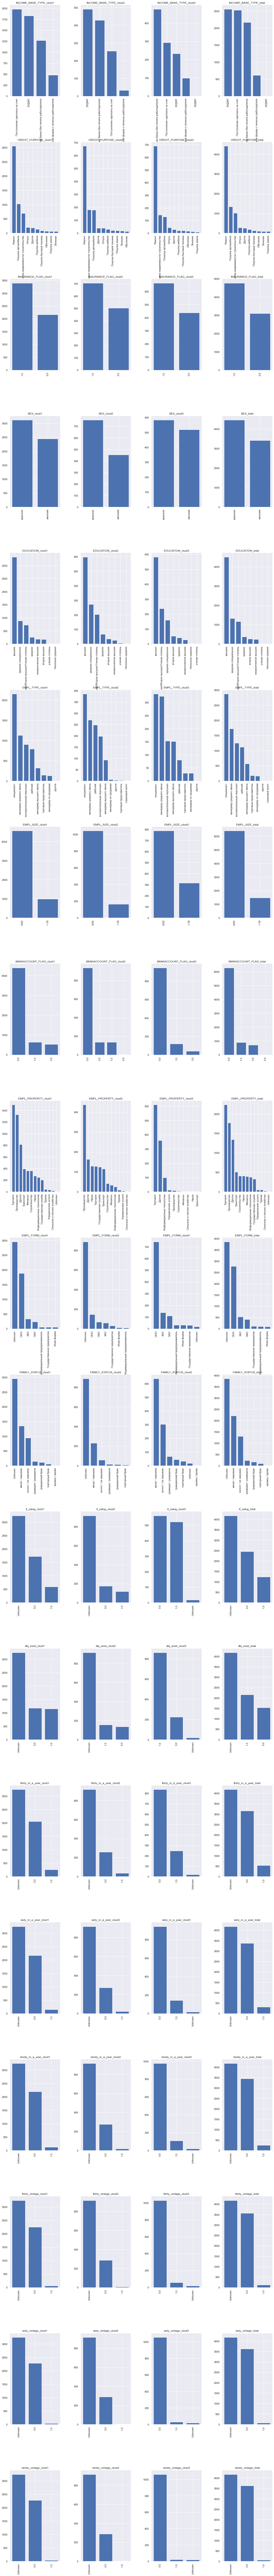

<Figure size 432x288 with 0 Axes>

In [1204]:
fig, ax = plt.subplots(19, 4, figsize=(20, 200))
i = 0
for col in cols:
    df_clust_1 = df[df['cluster'] == 0][col]
    df_clust_2 = df[df['cluster'] == 1][col]
    df_clust_3 = df[df['cluster'] == 2][col]
    ax[i][0].bar(np.arange(1, len(df_clust_1.value_counts()) + 1), df_clust_1.value_counts())
    ax[i][0].set_xticks(np.arange(1, len(df_clust_1.value_counts()) + 1))
    ax[i][0].set_xticklabels(df_clust_1.value_counts().index, rotation=90)
    ax[i][0].set_title(f'{col}_clust1')
    ax[i][1].bar(np.arange(1, len(df_clust_2.value_counts()) + 1), df_clust_2.value_counts())
    ax[i][1].set_xticks(np.arange(1, len(df_clust_2.value_counts()) + 1))
    ax[i][1].set_xticklabels(df_clust_2.value_counts().index, rotation=90)
    ax[i][1].set_title(f'{col}_clust2')
    ax[i][2].bar(np.arange(1, len(df_clust_3.value_counts()) + 1), df_clust_3.value_counts())
    ax[i][2].set_xticks(np.arange(1, len(df_clust_3.value_counts()) + 1))
    ax[i][2].set_xticklabels(df_clust_3.value_counts().index, rotation=90)
    ax[i][2].set_title(f'{col}_clust3')
    ax[i][3].bar(np.arange(1, len(df[col].value_counts()) + 1), df[col].value_counts())
    ax[i][3].set_xticks(np.arange(1, len(df[col].value_counts()) + 1))
    ax[i][3].set_xticklabels(df[col].value_counts().index, rotation=90)
    ax[i][3].set_title(f'{col}_total')
    i += 1
#fig.tight_layout(pad=3)
plt.subplots_adjust(hspace=0.5, wspace=0.4)
plt.show()

In [1179]:
numeric_plot = ['DTI',
 'FULL_AGE_CHILD_NUMBER',
 'DEPENDANT_NUMBER',
 'Period_at_work',
 'age',
 'max90days',
 'max60days',
 'max30days',
 'max21days',
 'max14days',
 'num_AccountActive180',
 'num_AccountActive90',
 'num_AccountActive60',
 'numAccountActiveAll',
 'numAccountClosed',
 'Active_not_cc',
 'own_closed',
 'min_MnthAfterLoan',
 'max_MnthAfterLoan',
 'all_credits_filled',
 'sum_of_paym_months_filled',
 'Active_to_All_prc_filled',
 'avg_num_delay_filled']

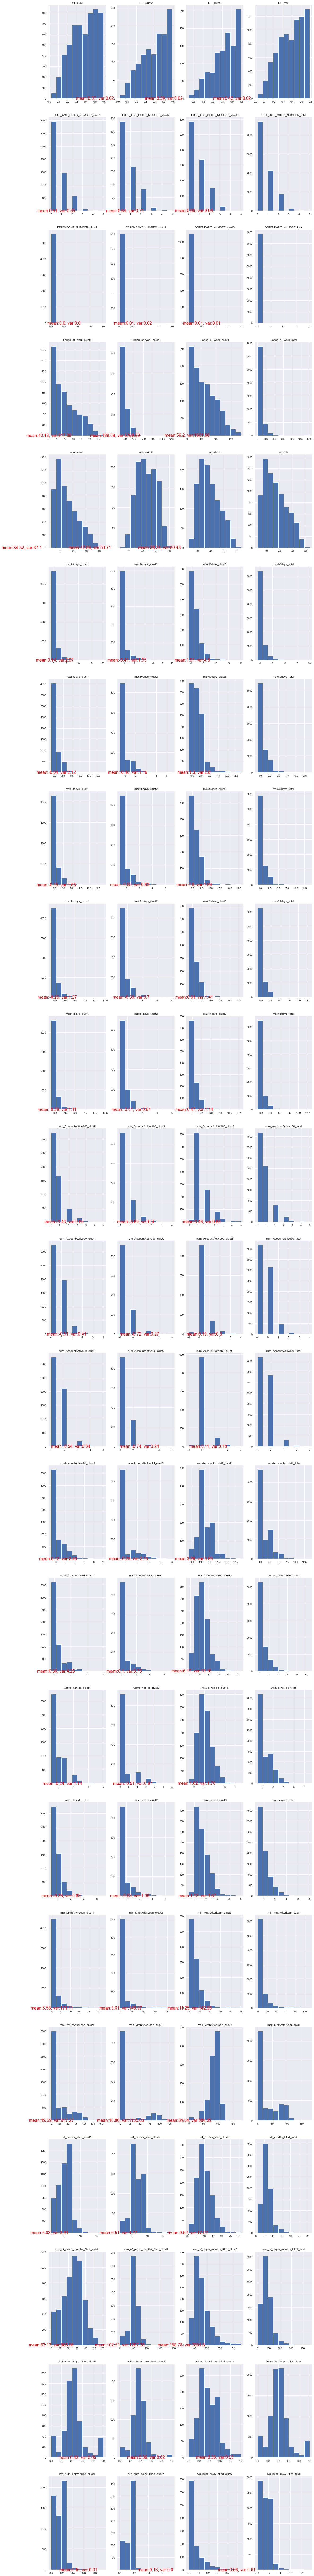

In [1197]:
fig, ax = plt.subplots(23, 4, figsize=(20, 200))
i = 0
for col in numeric_plot:
    df_clust_1 = df[df['cluster'] == 0][col]
    df_clust_2 = df[df['cluster'] == 1][col]
    df_clust_3 = df[df['cluster'] == 2][col]
    ax[i][0].hist(df_clust_1)
    ax[i][0].set_title(f'{col}_clust1')
    ax[i][0].text(0.5 ,0.5, f'mean:{np.round(df_clust_1.mean(), 2)}, var:{np.round(df_clust_1.var(), 2)}', 
                 fontdict={'color':'red', 'fontsize':18}, horizontalalignment='center', verticalalignment='center')
    ax[i][1].hist(df_clust_2)
    ax[i][1].set_title(f'{col}_clust2')
    ax[i][1].text(0.5 ,0.5, f'mean:{np.round(df_clust_2.mean(), 2)}, var:{np.round(df_clust_2.var(), 2)}', 
                 fontdict={'color':'red', 'fontsize':18}, horizontalalignment='center', verticalalignment='center')
    ax[i][2].hist(df_clust_3)
    ax[i][2].set_title(f'{col}_clust3')
    ax[i][2].text(0.5 ,0.5, f'mean:{np.round(df_clust_3.mean(), 2)}, var:{np.round(df_clust_3.var(), 2)}', 
                 fontdict={'color':'red', 'fontsize':18}, horizontalalignment='center', verticalalignment='center')
    ax[i][3].hist(df[col])
    ax[i][3].set_title(f'{col}_total')
    i += 1
""" print(f'Clust1 mean:{df_clust_1.mean()}, var:{df_clust_1.var()},\
          Clust2 mean:{df_clust_2.mean()}, var:{df_clust_2.var()}, \
          Clust3 mean:{df_clust_2.mean()}, var:{df_clust_3.var()}') """
    
#fig.tight_layout(pad=3)
plt.show()

* Основная цель у всех ремонт, далее автомобиль и строительство, одинаковая доля со страховкой

|  |                    |              |||||||
|---|---|---| --- | --- | --- | --- | --- | --- |
|Кластер 1| Поступление + 2НДФЛ | средне женщин | выборочное | торговля + произв-во | - | - | - | - |
|Кластер 2| 2НДФЛ + из банка    | меньше женщин | больше рабочих | произв-во | - | -| - | - |
|Кластер 3| Из банка + зарплата на счет| много женщин | больше средних менеджеров | торговля | женат | нет залога| есть задолж-ть| не было 30+|

|  |                    |              |||||||| первый и последний| кредитов | в месяц |задержка
|---|---|---| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
|Кластер 1|                 |              меньше |                           |  35, много до 30| -              | неизвестно, 0 | неизвестно, 0-7 | неизвестно, 0-2 | неизвестно, 0| 6, 20|5|63| 0.15|
|Кластер 2|                 |                     | большое время работы(189) |  43             | -              | неизвестно, 0 | неизвестно, 0-10 | неизвестно, 0-1 | неизвестно, 0| 4, 17|7|103|0.13|
|Кластер 3|выше средний DTI |больше доля с детьми |                           |  38             |много запросов  |больше аккаунтов |больше закрытых (5-25)|больше active_not_cc(2) | own_closed 2| 11, 84 |10|160|0.06|

# RFM segmentation

* Recency: min_MnthAfterLoan
* Frequency: all_credits
* Monetisation: sum_of_paym_months

In [1352]:
df_new = pd.read_csv('HW1_var_12.csv', sep=';')

In [1353]:
df_new = df_new[(df_new['min_MnthAfterLoan'].notna()) &
                (df_new['all_credits'].notna()) & 
                (df_new['sum_of_paym_months'].notna()) &
               (df_new['min_MnthAfterLoan'] != 0)]

In [1357]:
col = 'min_MnthAfterLoan'
new_col = 'R'

df_new[new_col] = (df_new[col] < np.quantile(df_new[col], 1/3)) * 1 + \
df_new[col].between(np.quantile(df_new[col], 1/3), np.quantile(df_new[col], 2/3)) * 2 + \
(df_new[col] > np.quantile(df_new[col], 2/3)) * 3

In [1360]:
for col, new_col in zip(['all_credits', 'sum_of_paym_months'], ['F','M']):
    df_new[new_col] = (df_new[col] < np.quantile(df_new[col], 1/3)) * 3 + \
df_new[col].between(np.quantile(df_new[col], 1/3), np.quantile(df_new[col], 2/3)) * 2 + \
(df_new[col] > np.quantile(df_new[col], 2/3)) * 1

In [1377]:
df_new['segm'] = np.zeros(len(df_new))

In [ ]:
df_new['segm'][(df_new['R'] == df_new['F']) & (df_new['R'] == df_new['M']) & (df_new['R'] ==1)] = 1
df_new['segm'][(df_new['R'] == df_new['F']) & (df_new['R'] == df_new['M']) & (df_new['R'] ==3)] = 2
df_new['segm'][(df_new['R'] == 1) & (df_new['F'] == 1) & (df_new['M'] != 1)] = 3
df_new['segm'][(df_new['F'] == 3) &  (df_new['R'].isin([2, 3])) & (df_new['M'].isin([1, 2]))] = 4
df_new['segm'][(df_new['F'] == 3) & (df_new['R'] == 2) & (df_new['M'] == 3)] = 5
df_new['segm'][(df_new['R'] == 1) & (df_new['F'] == 3)] = 6
df_new['segm'][(df_new['R'] == 1) & (df_new['F'] == 2) & (df_new['M'].isin([1,2]))] = 7
df_new['segm'][(df_new['R'] == 2) & (df_new['F'] == 2) & (df_new['M'].isin([1,2]))] = 8
df_new['segm'][(df_new['R'] == 2) & (df_new['F'] == 1) & (df_new['M'].isin([1,2]))] = 9
df_new['segm'][(df_new['R'] == 3) & (df_new['F'] == 1)] = 10
df_new['segm'][(df_new['R'] == 3) & (df_new['F'] == 2)] = 11
df_new['segm'][(df_new['R'].isin([1,2])) & (df_new['F'] == 2) & (df_new['M'] == 3)] = 12
df_new['segm'][(df_new['R'] == 2) & (df_new['F'] == 1) & (df_new['M'] == 3)] = 12

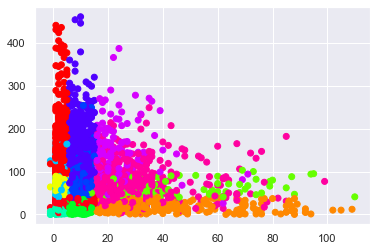

In [1401]:
plt.scatter(df_new['min_MnthAfterLoan'], df_new['sum_of_paym_months'], c=df_new['segm'], cmap='hsv')

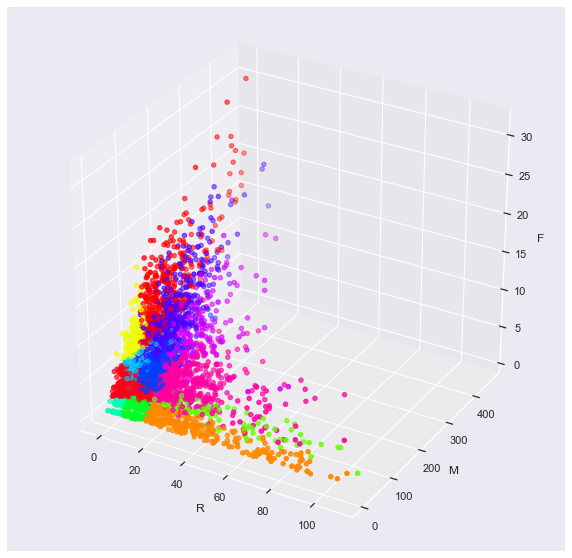

In [1536]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_new['min_MnthAfterLoan'], df_new['sum_of_paym_months'], df_new['all_credits'], c=df_new['segm'], cmap='hsv')
ax.set_xlabel('R')
ax.set_ylabel('M')
ax.set_zlabel('F')
plt.savefig('RFM_scatter')

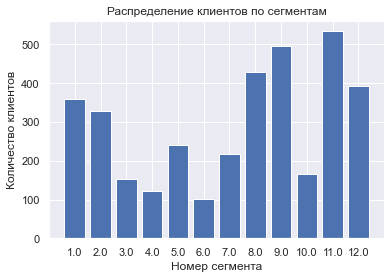

In [1530]:
plt.bar(np.arange(1, len(df_new['segm'].value_counts()) + 1), df_new['segm'].value_counts().sort_index())
plt.xticks(np.arange(1, len(df_new['segm'].value_counts()) + 1), df_new['segm'].value_counts().sort_index().index)
plt.title('Распределение клиентов по сегментам')
plt.xlabel('Номер сегмента')
plt.ylabel('Количество клиентов')
plt.savefig('RFM_segment_count')
plt.show()

In [1479]:
def plot_segm(segm, df, columns):
    num_cols = len(columns)
    fig, ax = plt.subplots(1, num_cols, figsize=(50, 10))
    for i, col in enumerate(columns):
        if type(df[col].iloc[0]) == str:
            ax[i].bar(np.arange(1, len(df[df['segm']==segm][col].value_counts()) + 1), 
                      df[df['segm']==segm][col].value_counts())
            ax[i].set_xticks(np.arange(1, len(df[df['segm']==segm][col].value_counts()) + 1))
            ax[i].set_xticklabels(df[df['segm']==segm][col].value_counts().index, rotation=30, ha='right')
            ax[i].set_title(f'{col}_segment_{segm}')
        else:
            ax[i].hist(df[df['segm']==segm][col])
            ax[i].set_title(f'{col}_segment_{segm}')
    plt.show()

In [1481]:
columns = ['INCOME_BASE_TYPE', 'CREDIT_PURPOSE', 'age', 'FAMILY_STATUS', 'avg_num_delay', 'EDUCATION', 'EMPL_TYPE']

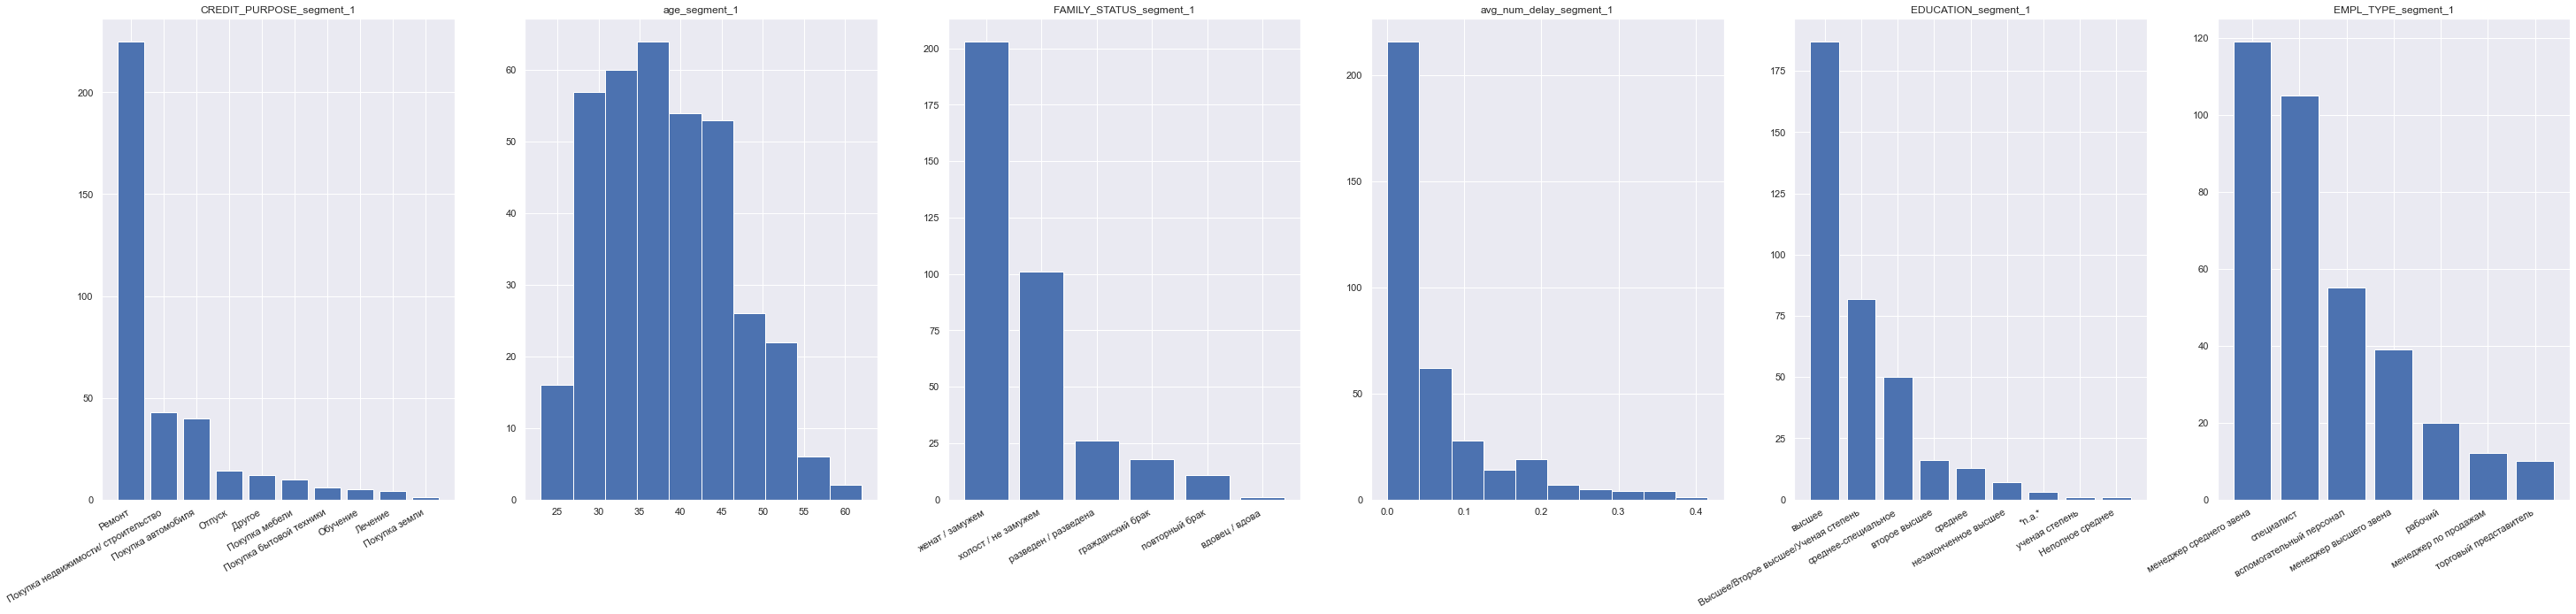

In [1482]:
plot_segm(1, df_new, columns)

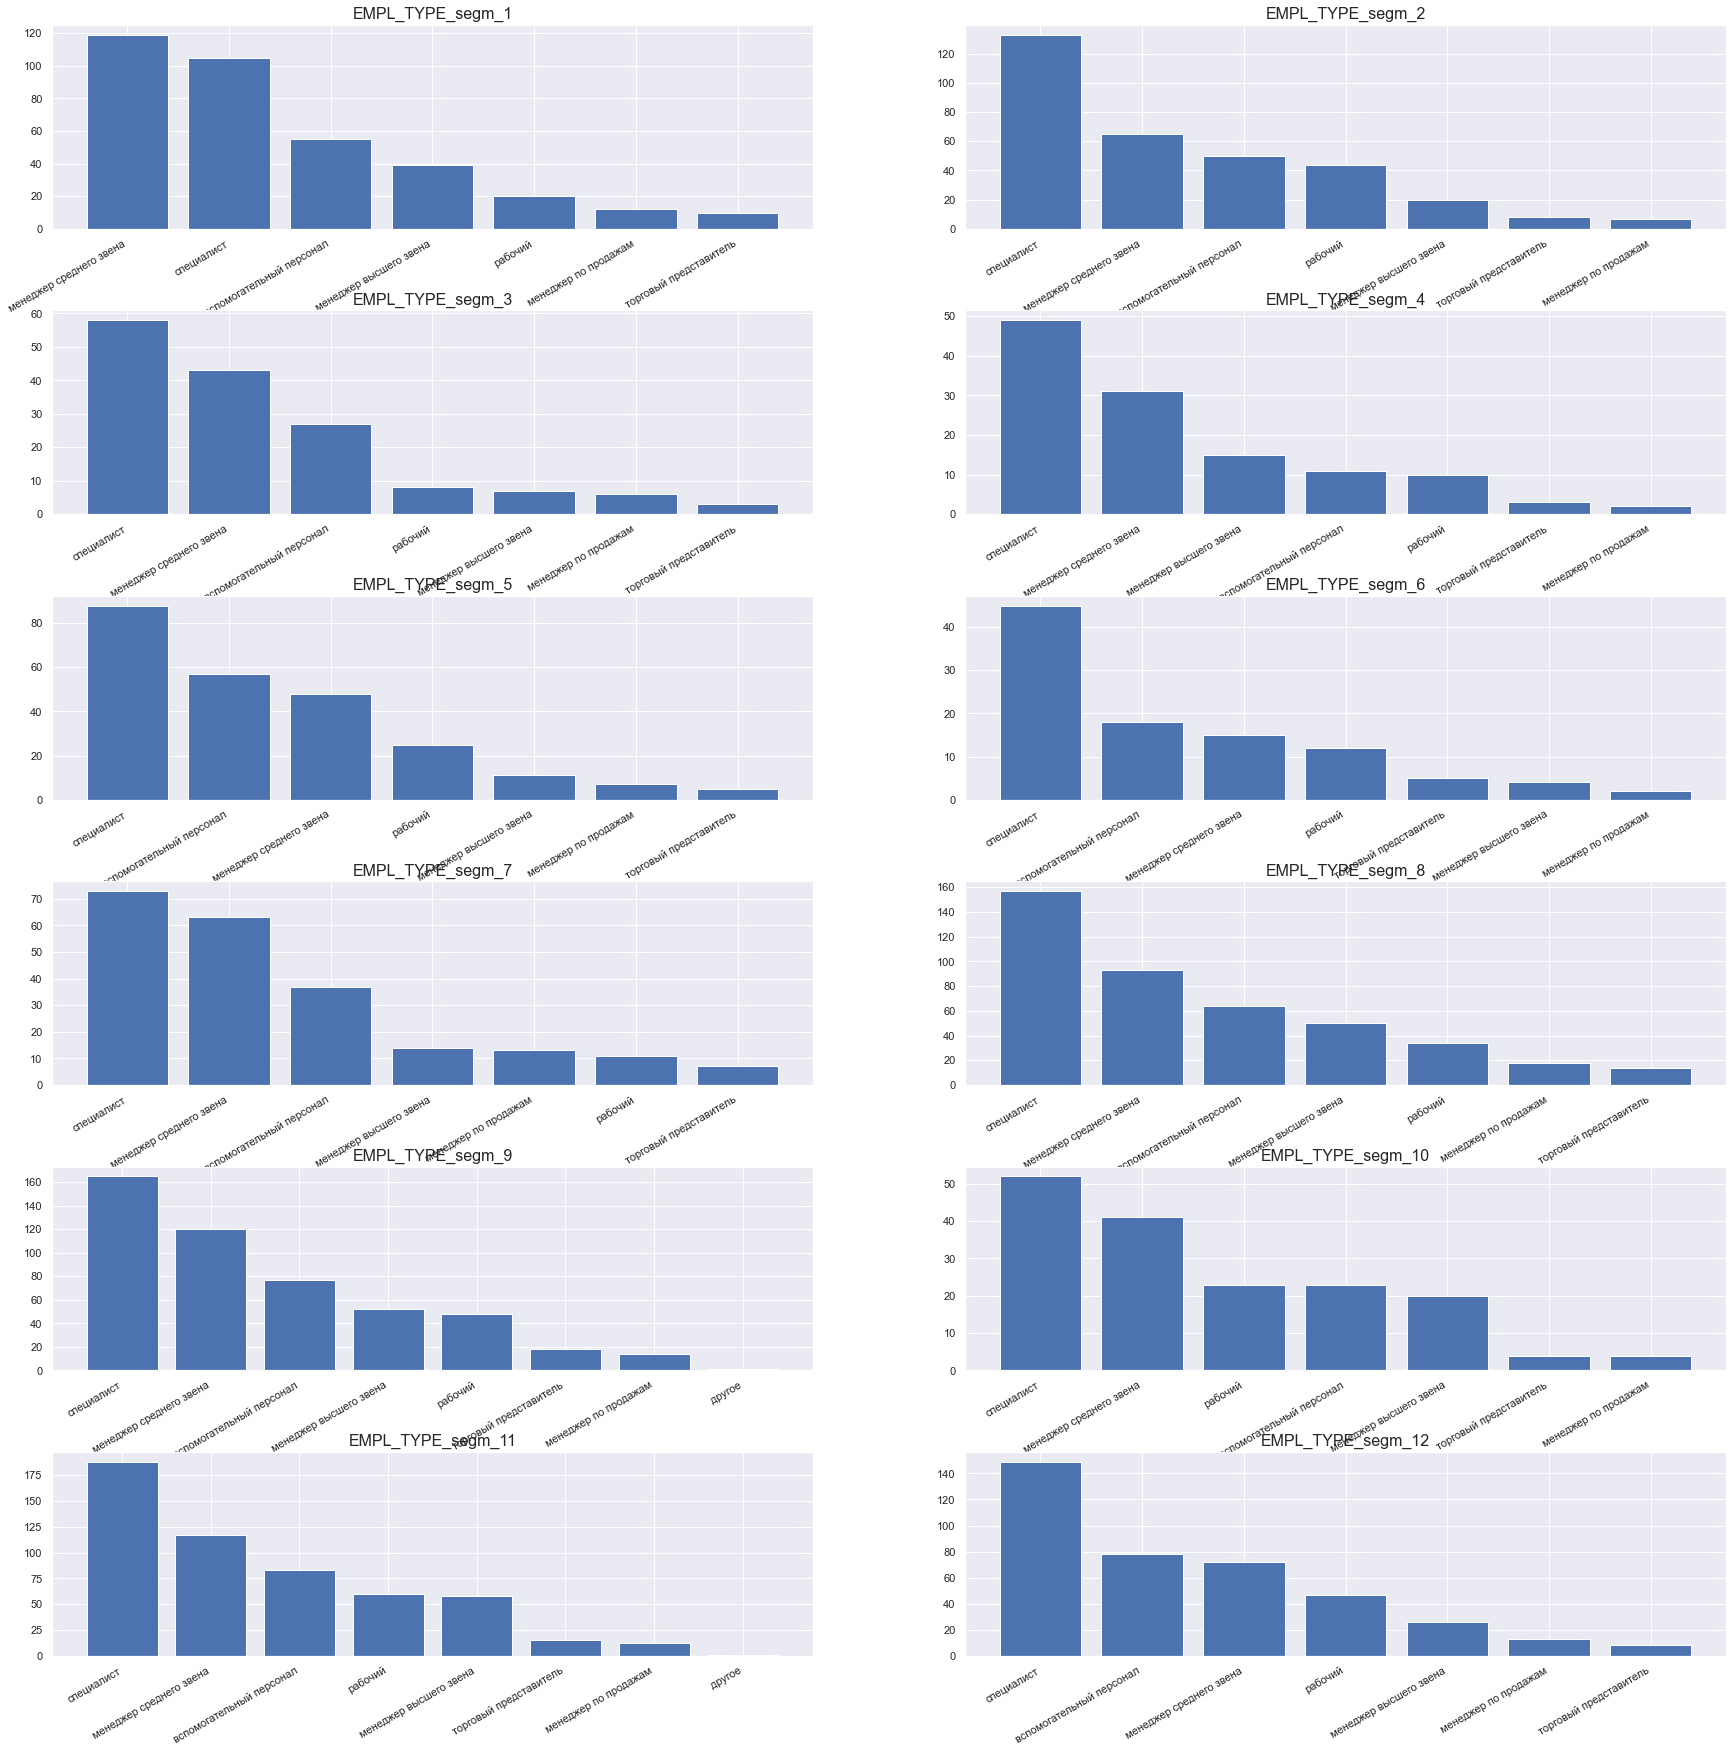

In [1561]:
fig, ax = plt.subplots(6, 2, figsize=(30, 30))
segm_list = np.arange(1,13)
segm_ind = 0
col = 'EMPL_TYPE'
for i in range(6):
    for j in range(2):
        segm = segm_list[segm_ind]
        """ax[i][j].hist(df_new[df_new['segm']==segm][col])
        ax[i][j].set_title(f'{col}_segm_{segm}', fontsize=16)
        segm_ind += 1
        mean = np.round(df_new[df_new['segm']==segm][col].mean(), 2)
        ax[i][j].text(0.5 ,0.5, f"mean:{mean}", 
                      fontdict={'color':'red', 'fontsize':18}, horizontalalignment='right', verticalalignment='center')"""

        ax[i][j].bar(np.arange(1, len(df_new[df_new['segm']==segm][col].value_counts()) + 1), 
                      df_new[df_new['segm']==segm][col].value_counts())
        ax[i][j].set_xticks(np.arange(1, len(df_new[df_new['segm']==segm][col].value_counts()) + 1))
        ax[i][j].set_xticklabels(df_new[df_new['segm']==segm][col].value_counts().index, rotation=30, ha='right')
        ax[i][j].set_title(f'{col}_segm_{segm}', fontsize=16)
        segm_ind += 1
plt.subplots_adjust(hspace=0.4)

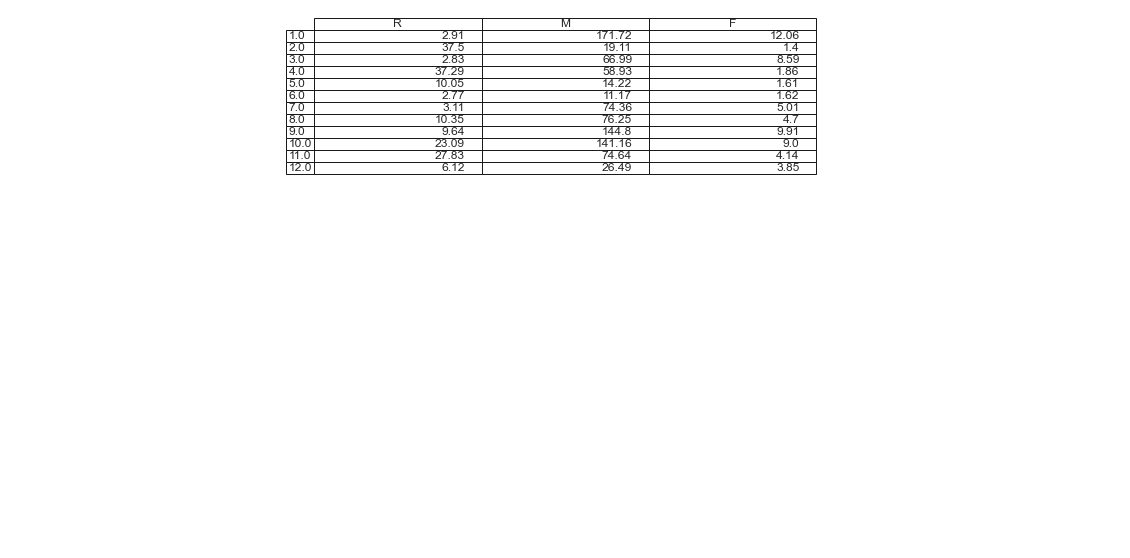

In [1552]:
plt.figure(figsize=(20, 10))
ax = plt.subplot(111, frame_on=False)
ax.xaxis.set_visible(False) 
ax.yaxis.set_visible(False)  

table(ax, df_new.groupby('segm').mean()[['min_MnthAfterLoan', 'sum_of_paym_months', 'all_credits']].round(2).rename(
    columns={'min_MnthAfterLoan':'R', 'sum_of_paym_months':'M', 'all_credits':'F'}),  
                                                    loc=8, 
      fontsize=50, colWidths=np.full(42, 0.15))
plt.savefig('RFM_segm_means')
plt.show()